# METİN MADENCİLİĞİ VE DOĞAL DİL İŞLEMEYE GİRİŞ

#### Duygu analizi ve duygu modelleme (Sentiment Analysis and Sentiment Modeling)

In [1]:
# !pip install nltk
# !pip install textblob
# !pip install wordcloud

In [2]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [3]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
# 1. Text Preprocessing
# 2. Text Visualization
# 3. Sentiment Analysis
# 4. Feature Engineering
# 5. Sentiment Modeling

Bu datasette Amazon'da bir ürün için yapılan yorumlar üzerinden metin madenciliği adımları gerçekleştirilerek metin sınıflandırma ve duygu analizi yapılacaktır.

# 1. Text Preprocessing (Metin Ön İşleme)

In [5]:
df = pd.read_csv("datasets/amazon_reviews.csv", sep=",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


##### Önemli bazı değişkenleri tanıyalım.
* reviewerID : yorum yapan kişi
* reviewText : kişinin yaptığı yorum 
* overall : kişinin ürüne verdiği puan

##### Büyük/küçük harfi normalize edelim. (Normalizing Case Folding)

In [6]:
df['reviewText']

0                                              No issues.
1       Purchased this for my device, it worked as adv...
2       it works as expected. I should have sprung for...
3       This think has worked out great.Had a diff. br...
4       Bought it with Retail Packaging, arrived legit...
                              ...                        
4910    I bought this Sandisk 16GB Class 10 to use wit...
4911    Used this for extending the capabilities of my...
4912    Great card that is very fast and reliable. It ...
4913    Good amount of space for the stuff I want to d...
4914    I've heard bad things about this 64gb Micro SD...
Name: reviewText, Length: 4915, dtype: object

In [7]:
df['reviewText'] = df['reviewText'].str.lower()
df['reviewText'].head()

0                                           no issues.
1    purchased this for my device, it worked as adv...
2    it works as expected. i should have sprung for...
3    this think has worked out great.had a diff. br...
4    bought it with retail packaging, arrived legit...
Name: reviewText, dtype: object

##### Noktalama işaretlerini silelim. Bunu regex kullanarak gerçekleştirebiliriz.

regular expression : metinsel ifadelerde belirli bir örüntü yakalayıp bunu tanımlamak ve üzerinde çalışmak için kullanılan bir yapı.

In [8]:
# regex
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')
df['reviewText'].head(10)

0                                            no issues
1    purchased this for my device it worked as adve...
2    it works as expected i should have sprung for ...
3    this think has worked out greathad a diff bran...
4    bought it with retail packaging arrived legit ...
5    its mini storage  it doesnt do anything else a...
6    i have it in my phone and it never skips a bea...
7    its hard to believe how affordable digital has...
8    works in a htc rezound  was running short of s...
9    in my galaxy s4 super fast card and am totally...
Name: reviewText, dtype: object

##### Sayıları silelim.

In [9]:
df['reviewText'] = df['reviewText'].str.replace('\d', '')
df['reviewText'].head(10)

0                                            no issues
1    purchased this for my device it worked as adve...
2    it works as expected i should have sprung for ...
3    this think has worked out greathad a diff bran...
4    bought it with retail packaging arrived legit ...
5    its mini storage  it doesnt do anything else a...
6    i have it in my phone and it never skips a bea...
7    its hard to believe how affordable digital has...
8    works in a htc rezound  was running short of s...
9    in my galaxy s super fast card and am totally ...
Name: reviewText, dtype: object

##### Stopwords'leri silelim.

Stopwords : Dilde yaygın kullanılan fakat ölçüm niteliği taşımayan, herhangi bir anlamı olmayan kelimeler. NLTK kütüphanesinin içinde stopwords listesi vardır.

In [10]:
import nltk
# nltk.download('stopwords')

In [11]:
# indirdiğimiz stopwordsleri sw adında değişkene kaydedelim.
sw = stopwords.words('english')
sw[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [12]:
# stopwordsleri silelim.
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df['reviewText'].head(20)

0                                                issues
1     purchased device worked advertised never much ...
2     works expected sprung higher capacity think ma...
3     think worked greathad diff bran gb card went s...
4     bought retail packaging arrived legit orange e...
5     mini storage doesnt anything else supposed pur...
6     phone never skips beat file transfers speedy c...
7     hard believe affordable digital become gb devi...
8     works htc rezound running short space gb sandi...
9     galaxy super fast card totally happy happy sti...
10    like sd card take music video downloads person...
11    works file writes bit slower expected usb read...
12                            name speaks go sandisk go
13    solid sdhc card fast reading writing fast reco...
14    heard cards write speed insufficient however u...
15    bought use go pro hero black edition requires ...
16    got gb one filled kept getting insufficient di...
17    class speed rating seamless full hd videot

##### Nadir geçen kelimeleri silelim.

Her bir kelimenin kaçar defa geçtiğini bulalım. Bunu temp_df isimli geçici bir dataframede tutalım. Nadir geçenleri silelim.

In [13]:
temp_df = pd.Series(' '.join(df['reviewText']).split()).value_counts()
temp_df

card               4603
gb                 1725
phone              1685
works              1559
great              1445
                   ... 
relative              1
chipsetgogroove       1
suffering             1
tabletam              1
hat                   1
Length: 9701, dtype: int64

In [14]:
# sadece 1 defa geçen kelimeler
drops = temp_df[temp_df <= 1]
drops

phoneback          1
unrecognized       1
responsibility     1
hefty              1
mccoy              1
                  ..
relative           1
chipsetgogroove    1
suffering          1
tabletam           1
hat                1
Length: 5612, dtype: int64

In [15]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))
df['reviewText'].head(20)

0                                                issues
1     purchased device worked advertised never much ...
2     works expected higher capacity think made bit ...
3     think worked gb card went south one held prett...
4     bought retail packaging arrived legit envelope...
5     mini storage doesnt anything else supposed pur...
6     phone never skips beat file transfers speedy c...
7     hard believe affordable digital become gb devi...
8     works htc rezound running short space gb sandi...
9     galaxy super fast card totally happy happy sti...
10    like sd card take music video downloads person...
11    works file writes bit slower expected usb read...
12                            name speaks go sandisk go
13    solid sdhc card fast reading writing fast reco...
14    heard cards write speed insufficient however u...
15    bought use go pro hero black edition requires ...
16    got gb one filled kept getting insufficient di...
17    class speed rating seamless full hd sandis

##### Tokenization

token'larına ayırmak : cümleleri parçalamak, birimleştirmek

In [16]:
# nltk.download("punkt")

In [17]:
df["reviewText"].apply(lambda x: TextBlob(x).words).head()  # atama yapmadık

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, higher, capacity, think, mad...
3    [think, worked, gb, card, went, south, one, he...
4    [bought, retail, packaging, arrived, legit, en...
Name: reviewText, dtype: object

##### Lemmatization   

Kelimeleri köklerine indirgeme işlemidir!

not : 'Stemming' de bir köklerine ayırma işlemidir.

In [18]:
# nltk.download('wordnet')

In [19]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['reviewText']

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used capability samsung galaxy note greatly ex...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewText, Length: 4915, dtype: object

# 2. Text Visualization (Metin Görselleştirme)

Metinleri sayısal bi şekilde ifade etmeye çalışalım. Örneğin frekanslarını bulalım.

##### Terim Frekanslarının Hesaplanması

In [20]:
tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf

,index,0
0,issue,609.00
1,lot,403.00
2,never,358.00
3,worked,460.00
4,brainer,9.00
...,...,...
3683,pureview,3.00
3684,laptoptablet,2.00
3685,employee,2.00
3686,sandisksequential,2.00


In [21]:
tf.columns = ["words", "tf"]

In [22]:
tf.sort_values("tf", ascending=False)

,words,tf
27,card,5537.00
20,work,2044.00
11,phone,1909.00
36,gb,1756.00
85,great,1445.00
...,...,...
2721,sizethe,2.00
2719,everybody,2.00
2717,lived,2.00
3687,chkdsk,2.00


##### Barplot

In [23]:
tf[tf["tf"] > 500].head()

,words,tf
0,issue,609.00
8,memory,1378.00
9,device,584.00
11,phone,1909.00
20,work,2044.00


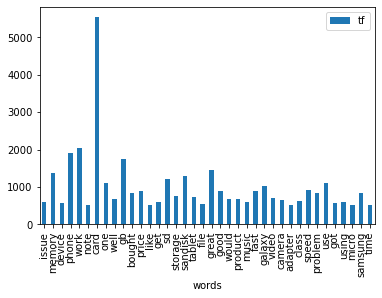

In [24]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

##### Örneğin düşük puan (overall) verenlerin yorumlarda en çok kullandığı kelimeleri görselleştirelim.

In [25]:
df['overall'].value_counts() #3ten az puan verenler kalsın.

5.00    3922
4.00     527
1.00     244
3.00     142
2.00      80
Name: overall, dtype: int64

In [26]:
df_new = df[df['overall']<3]

tf = df_new["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.sort_values("tf", ascending=True)

,words,tf
2141,cancelled,1.00
781,knockoff,1.00
784,boost,1.00
787,roku,1.00
1668,recomend,1.00
...,...,...
253,problem,139.00
15,gb,210.00
1,sandisk,262.00
9,phone,269.00


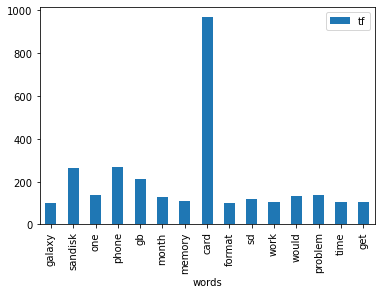

In [27]:
# tf'i 100den büyük olan kelimeleri görselleştirdik.
tf[tf["tf"] > 100].plot.bar(x="words", y="tf")
plt.show()

##### Wordcloud

ilgili metindeki kelimelerin geçme frekanslarına göre bir bulut şeklinde görsel oluşturulması işi.

In [28]:
# tüm metni tek bir metin olarak bir araya getirelim.
text = " ".join(i for i in df.reviewText)

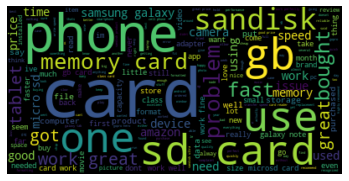

In [29]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

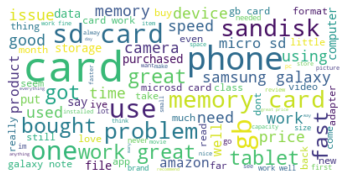

In [30]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [31]:
# elde ettiğimiz diziyi çalışma dizinine kaydettik
wordcloud.to_file("wordcloud.png")

##### Şablonlara Göre Wordcloud

In [32]:
tr_mask = np.array(Image.open("tr.png"))

In [33]:
wc = WordCloud(background_color="white",
               max_words=1000,
               mask=tr_mask,
               contour_width=3,
               contour_color="firebrick")

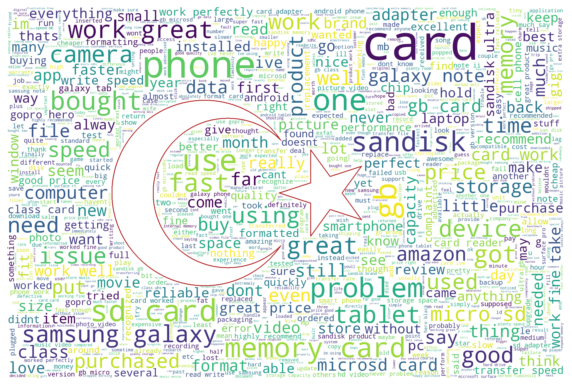

In [34]:
wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3. Sentiment Analysis (Duygu Durum Analizi)

Metinlerin taşıdığı duygu durumunu matematiksel bir biçimde ifade etmeyi amaçlayar.

In [35]:
df["reviewText"].head()

0                                                issue
1    purchased device worked advertised never much ...
2    work expected higher capacity think made bit e...
3    think worked gb card went south one held prett...
4    bought retail packaging arrived legit envelope...
Name: reviewText, dtype: object

In [36]:
#nltk.download('vader_lexicon')

In [37]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The film was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [38]:
sia.polarity_scores("I liked this music but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

polarity_score : pozitif negatif skor. 'Compound' özelliğine odaklanacağız. -1 ve +1 arasında değer alır.

In [39]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...
3    {'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'comp...
4    {'neg': 0.0, 'neu': 0.747, 'pos': 0.253, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.108, 'neu': 0.598, 'pos': 0.295, 'co...
7    {'neg': 0.077, 'neu': 0.65, 'pos': 0.272, 'com...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.457, 'pos': 0.543, 'comp...
Name: reviewText, dtype: object

In [40]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.00
1   0.00
2   0.40
3   0.65
4   0.86
5   0.00
6   0.87
7   0.82
8   0.00
9   0.92
Name: reviewText, dtype: float64

Veri setimizin içindeki tüm yorumların duygu skorlarını çıkardık. Şimdi bu skorları kalıcı bir şekilde Dataframe içine gönderelim.

In [41]:
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86


#### Peki sonra neler yapılabilir?
polarity_score değeri 0'dan büyük olup verdiği puan (overall) 3'ten küçük olanlar incelenip bu tezatlıklar üzerinden belirli çıkarımlarda bulunabiliriz. Yani ürüne düşük puan vermiş ama yorumu pozitif, bunlara odaklanılabilir.

In [42]:
df_t = df[df['polarity_score']>0]
df_t[df_t['overall']<3]['reviewText']

38      bougth micro sd card got kingston tell sandisk...
108     work actual rw speed mb even class sandisk bas...
123     bought gb version card use gopro hero black ed...
150     used galaxy note past month sudden longer trie...
177     use sdxc card gb card unreadable arrival pc sa...
                              ...                        
4770    bought two back gopro hero one amazon gift wor...
4847    purchased galaxie phone fit work much else say...
4867    buyer beware card unreadable get go luck amazo...
4892    card great price plenty speed worked year fact...
4910    bought sandisk gb class use htc inspire month ...
Name: reviewText, Length: 149, dtype: object

# 4. Feature Engineering (Özellik Mühendisliği)

In [43]:
# compound değerine göre label oluşturalım. (üstteki yöntemden bağımsız olarak 2. bir yol)
df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    neg
1    neg
2    pos
3    pos
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: reviewText, dtype: object

In [44]:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["sentiment_label"].head()

0    neg
1    neg
2    pos
3    pos
4    pos
Name: sentiment_label, dtype: object

In [45]:
df["sentiment_label"].value_counts()

pos    3944
neg     971
Name: sentiment_label, dtype: int64

In [46]:
df.groupby("sentiment_label")["overall"].mean()

sentiment_label
neg   4.09
pos   4.71
Name: overall, dtype: float64

Negatif olarak etiketlenmiş olan sınıfın overall ortalaması pozitif olarak etiketlenmiş olandan düşük.

##### bağımlı değişken : sentiment_label

In [47]:
# Bağımlı değişkeni label encoderdan geçirelim
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])
df["sentiment_label"].head()

0    0
1    0
2    1
3    1
4    1
Name: sentiment_label, dtype: int32

Bağımlı değişkeni kullanacağımız makine öğrenmesi yöntemlerinin anlayabileceği dile çevirdik.

In [48]:
y = df["sentiment_label"]
X = df["reviewText"]

#### X'leri ölçülebilir bir formata dönüştürmeliyiz.

Amaç : Bağımsız değişkenden (metinden) ölçülebilirlik özelliğine sahip olan, matematiksel işlemler yapabileceğimiz, makine öğrenmesi modelleri uygulayabileceğimiz değişkenler üretmektir. Yani elimizdeki metni, lineer cebir dünyasında işlenebilecek hale getirmeliyiz.

Elimizde metin var. Bu metnin içinden feature'lar üretmek lazım. Ölçülebilirlik özelliğine sahip olan, matematiksel işlemler yapılabilir hale getirmek lazım. Yani kelimelerin sayısal olarak temsil edilmesi (lineer cebir dünyasında işlenebilir bir hale getirilmesi). Vektörleştirilmesi !

#### Yaygın kullanılan kelime vektörü oluşturma yöntemleri

* Count Vectors: frekans temsiller
* TF-IDF Vectors: normalize edilmiş frekans temsiller
* Word Embeddings (Word2Vec, GloVe, BERT vs)

### Count Vectors

In [49]:
# ngram
a = """Bu örneği anlaşılabilmesi için daha uzun bir metin üzerinden göstereceğim.
N-gram'lar birlikte kullanılan kelimelerin kombinasyolarını gösterir ve feature üretmek için kullanılır"""

TextBlob(a).ngrams(3)

[WordList(['Bu', 'örneği', 'anlaşılabilmesi']),
 WordList(['örneği', 'anlaşılabilmesi', 'için']),
 WordList(['anlaşılabilmesi', 'için', 'daha']),
 WordList(['için', 'daha', 'uzun']),
 WordList(['daha', 'uzun', 'bir']),
 WordList(['uzun', 'bir', 'metin']),
 WordList(['bir', 'metin', 'üzerinden']),
 WordList(['metin', 'üzerinden', 'göstereceğim']),
 WordList(['üzerinden', 'göstereceğim', "N-gram'lar"]),
 WordList(['göstereceğim', "N-gram'lar", 'birlikte']),
 WordList(["N-gram'lar", 'birlikte', 'kullanılan']),
 WordList(['birlikte', 'kullanılan', 'kelimelerin']),
 WordList(['kullanılan', 'kelimelerin', 'kombinasyolarını']),
 WordList(['kelimelerin', 'kombinasyolarını', 'gösterir']),
 WordList(['kombinasyolarını', 'gösterir', 've']),
 WordList(['gösterir', 've', 'feature']),
 WordList(['ve', 'feature', 'üretmek']),
 WordList(['feature', 'üretmek', 'için']),
 WordList(['üretmek', 'için', 'kullanılır'])]

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

##### Cümlelerin ilgili metinde geçen kelime frekanslarına göre temsil edilişi ( word frekans )

In [51]:
# word frekans
vectorizer = CountVectorizer()
X_c = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

In [52]:
X_c.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

##### Cümlelerin n-gram ile oluşturulmuş kelime öbeklerine göre temsil edilişi

In [53]:
# n-gram frekans
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X_n = vectorizer2.fit_transform(corpus)
vectorizer2.get_feature_names()

['and this',
 'document is',
 'first document',
 'is the',
 'is this',
 'second document',
 'the first',
 'the second',
 'the third',
 'third one',
 'this document',
 'this is',
 'this the']

In [54]:
X_n.toarray()

array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]], dtype=int64)

##### Şimdi word frekans yöntemini kullanarak X bağımsız değişkenini (reviewText) temsil edelim.

In [55]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

vectorizer.get_feature_names()[10:15]


['access', 'accessed', 'accessible', 'accessing', 'accessory']

In [56]:
X_count.toarray()[10:15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### TF-IDF

Kelimelerin her bir dökümanda geçme frekansları ve tüm metinde geçme frekansları odağında bir standartlaştırma işlemi yaparak çalışır.

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
# kelimelere göre tf-ıdf 
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

In [59]:
# # n-gram'lara göre tf-ıdf
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

##### Model basağıma geçerken elimizde 3 dataset var.
* X_count : count vector yöntemi ile oluşturduk.
* X_tf_idf_word : keliemelere göre yapılmış tf-ıdf
* X_tf_idf_ngram : n-grama göre yapılmış tf-ıdf

Makine öğrenmesi bölümünde bu 3 farklı yöntemle üretilmiş değişkenlerden oluşan datasetleri deneyeceğiz.

# 5. Sentiment Modeling (Duygu Durum Modelleme)

Amaç : Bir metin sınıflandrıma modeli kurmak. Bu modele çeşitli yorumlar sorulduğunda pozitif mi negatif mi olduğunu tahmin etmek. Yani amaç 2li bi sınıflandırma problemi üzerinde modelleme yapmak.

### Logistic Regression

In [60]:
log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()

0.830111902339776

In [61]:
# yeni gelen bir yorumu modelde gözlemleyelim.
new_review = pd.Series("this product is great")

new_review = TfidfVectorizer().fit(X).transform(new_review)
log_model.predict(new_review)

array([1])

In [62]:
new_review = pd.Series("look at that shit very bad")
new_review = TfidfVectorizer().fit(X).transform(new_review)

log_model.predict(new_review)

array([0])

In [63]:
new_review = pd.Series("it was good but I am sure that it fits me")
new_review = TfidfVectorizer().fit(X).transform(new_review)

log_model.predict(new_review)

array([1])

In [64]:
# elimizdeki datasetten örnek bir yorum çekerek gözlemleyelim.
random_review = pd.Series(df["reviewText"].sample(1).values)
random_review

0    plug phone show sd card didnt give option form...
dtype: object

In [65]:
new_review = TfidfVectorizer().fit(X).transform(random_review)
log_model.predict(new_review)

array([1])

### Random Forests

3 farklı yöntem için doğruluk değerlerini gözlemleyelim.

In [66]:
# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

0.842115971515768

In [67]:
# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

0.8270600203458798

In [68]:
# TF-IDF N-GRAM
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)
cross_val_score(rf_model, X_tf_idf_ngram, y, cv=5, n_jobs=-1).mean()

0.7847405900305189

### Hiperparametre Optimizasyonu

In [69]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [8, None],
             "max_features": [7, "auto"],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200]}


In [70]:
rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=1).fit(X_count, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [71]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

Bu kombinasyondan gelen değerler ile final modelini oluşturalım.

In [72]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)

In [73]:
cross_val_score(rf_final, X_count, y, cv=5, n_jobs=-1).mean()

0.8408952187182095